<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Pneumonia_Identifier_Using_Chest_XRay_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:58<00:00, 52.6MB/s]
100% 2.29G/2.29G [00:58<00:00, 42.4MB/s]


In [3]:
! mkdir ./data
! unzip chest-xray-pneumonia.zip -d ./data > extract.log
! rm -rf chest-xray-pneumonia.zip

In [19]:
import os
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt

import torch
from torchvision.transforms import ToTensor
from torchvision.models import resnet18

In [5]:
class chest_xray_data(object):

  def __init__(self, root, split, transforms=None):
    self.root = root
    self.transforms = transforms
    self.data_dir = os.path.join(root, split)
    self.imgs = [(i, 'NORMAL') for i in list(sorted(os.listdir(os.path.join(self.data_dir, 'NORMAL'))))]
    self.imgs += [(i, 'PNEUMONIA') for i  in list(sorted(os.listdir(os.path.join(self.data_dir, 'PNEUMONIA'))))]

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.data_dir, self.imgs[idx][1], self.imgs[idx][0])
    img = Image.open(img_path).convert('RGB').resize((448, 448))
    img = np.moveaxis(np.array(img)/255.0, -1, 0)
    label = 0 if self.imgs[idx][1] == 'NORMAL' else 1
    if self.transforms is not None:
      img, label = self.transforms(img, label)
    return img, label


In [6]:
train_data = chest_xray_data('/content/data/chest_xray', 'train')
test_data = chest_xray_data('/content/data/chest_xray', 'test')

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_data, 32, True)
test_dataloader = torch.utils.data.DataLoader(test_data, 32, True)

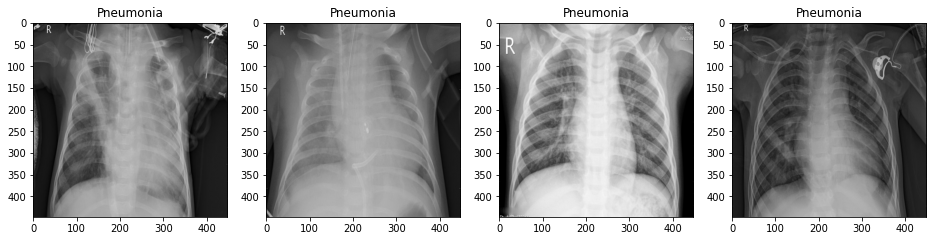

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in train_dataloader:
  for j in range(4):
    img = i[0][j]
    label = i[1][j]
    ax[j].imshow(np.moveaxis(img.numpy(), 0, -1))
    ax[j].set_title('Normal' if label == 0 else 'Pneumonia')
  break

In [34]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    pred = model(X.float())
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 16 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size*len(X):>5d}]")

In [27]:
def test(dataloader, model):
  size = len(dataloader.dataset)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X.float())
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [48]:
model = resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 2)

In [62]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-5, momentum=0.8, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else  'cpu'
num_epochs = 5
print(f"Model Is Running On {device}")

Model Is Running On cuda


In [63]:
test(test_dataloader, model.to(device))

Test Error: 
 Accuracy: 83.0%, Avg loss:0.012867 



In [ ]:
for i in range(num_epochs):
  print(f"Epoch {i+1}\n-------------------------------")
  train(train_dataloader, model.to(device), loss_fn, optimizer)
  test(test_dataloader, model.to(device))

Epoch 1
-------------------------------
loss: 0.150435  [    0/ 5216]
loss: 0.109797  [  512/ 5216]
loss: 0.132777  [ 1024/ 5216]
loss: 0.175347  [ 1536/ 5216]
loss: 0.102237  [ 2048/ 5216]
loss: 0.117339  [ 2560/ 5216]
loss: 0.120753  [ 3072/ 5216]
loss: 0.105761  [ 3584/ 5216]
loss: 0.192886  [ 4096/ 5216]
loss: 0.061149  [ 4608/ 5216]
loss: 0.220131  [ 5120/ 5216]
Test Error: 
 Accuracy: 80.9%, Avg loss:0.014655 

Epoch 2
-------------------------------
loss: 0.175537  [    0/ 5216]
loss: 0.142483  [  512/ 5216]
loss: 0.084332  [ 1024/ 5216]
loss: 0.097964  [ 1536/ 5216]
loss: 0.050773  [ 2048/ 5216]
loss: 0.208945  [ 2560/ 5216]
loss: 0.132429  [ 3072/ 5216]
loss: 0.030185  [ 3584/ 5216]
